In [1]:
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [2]:
# Prefetch用にどの程度先取りしておくか自動調整
# https://tensorflow.classcat.com/2019/03/23/tf20-alpha-guide-data-performance/
AUTO = tf.data.experimental.AUTOTUNE
# Kaggleのｎデータ拝借
from kaggle_datasets import KaggleDatasets

In [3]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Detect: TPU")
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU(インストールで入れた際に)
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
    print("Detect: GPU")

print("Number of accelerators: ", strategy.num_replicas_in_sync)
# tf.distribute.Strategyは、トレーニングを複数のGPU、複数のマシン、またはTPUに分散するためのTensorFlowAPIです。
# このAPIを使用すると、最小限のコード変更で既存のモデルとトレーニングコードを配布できます。
# https://tensorflow.classcat.com/2019/03/21/tf20-alpha-guide-distribute-strategy/

Detect: TPU
Number of accelerators:  8


In [4]:
# Kaggle dataset access
# TPUs read data directly from Google Cloud Storage (GCS). 
# This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. 
# If you have multiple datasets attached to the notebook,
# you can pass the name of a specific dataset to the get_gcs_path function. 
# The name of the dataset is the name of the directory it is mounted in. Use !ls /kaggle/input/ to list attached datasets.

GCS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_PATH

In [13]:
"""
Define image info
"""
# Dataset: https://www.kaggle.com/mgornergoogle/five-flowers
# TFRecord ファイル軍
EPOCHS = 12
IMAGE_SIZE = [331, 331]

# available image sizes
# train/test/val
FLOWERS_DATASETS = { 
    192: GCS_PATH + '/tfrecords-jpeg-192x192/*.tfrec',
    224: GCS_PATH + '/tfrecords-jpeg-224x224/*.tfrec',
    331: GCS_PATH + '/tfrecords-jpeg-331x331/*.tfrec',
    512: GCS_PATH + '/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"

In [6]:
# strategy.num_replicas_in_sync: #TPU  or #GPU: レプリカを各GPU/TPUで作成
BATCH_SIZE = 16 * strategy.num_replicas_in_sync 

Learning rate schedule: 1e-05 to 0.0004 to 0.000112


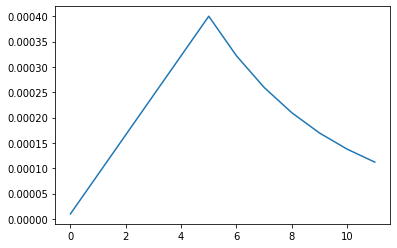

In [7]:
"""
learning rate scheduler
"""

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        #　以降指数的に減衰
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [8]:
"""
Data Loading Funcs
全て借り物関数
"""
#TPUはサイズに気をつけないといけないらしい
#https://cloud.google.com/tpu/docs/performance-guide#tf-fcts
# https://qiita.com/ohtaman/items/325615358f008a4005e2

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
        
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),# Load variable length feature
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3) # pixel format uint8 [0,255] range
    class_label = tf.cast(example['class'], tf.int32) # not used
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def force_image_sizes(dataset, image_size):
    # explicit size needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [12]:
FLOWERS_DATASETS

{192: 'gs://kds-0129b3386fbcffe667676f240e7c00e9907cc29bcc958a4c62d07834/tfrecords-jpeg-192x192/*.tfrec',
 224: 'gs://kds-0129b3386fbcffe667676f240e7c00e9907cc29bcc958a4c62d07834/tfrecords-jpeg-224x224/*.tfrec',
 331: 'gs://kds-0129b3386fbcffe667676f240e7c00e9907cc29bcc958a4c62d07834/tfrecords-jpeg-331x331/*/*.tfrec',
 512: 'gs://kds-0129b3386fbcffe667676f240e7c00e9907cc29bcc958a4c62d07834/tfrecords-jpeg-512x512/*.tfrec'}

In [14]:
"""
Split Data
"""
gcs_pattern = FLOWERS_DATASETS[IMAGE_SIZE[0]]
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
TRAINING_FILENAMES = filenames[:split]
VALIDATION_FILENAMES = filenames[split:]
TRAIN_STEPS = count_data_items(TRAINING_FILENAMES) // BATCH_SIZE
VALIDATION_STEPS = -(-count_data_items(VALIDATION_FILENAMES) // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print("TRAINING IMAGES: ", count_data_items(TRAINING_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALIDATION_FILENAMES))

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


In [17]:
IMAGE_SIZE

[331, 331]

In [10]:
# xceptionを利用
# https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/
#　VGGとかこの部分を変えればよい。
# ベつに自作してもよい。普通の画像分類
with strategy.scope():
    """
    Distributed Execution
    """
    # xception用のｎ前処理実行
    img_adjust_layer = tf.keras.layers.Lambda(
        lambda data: tf.keras.applications.xception.preprocess_input(
            tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])
    # xceptionモデルの組み込み
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
    #学習モード
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        #  GAP>Flat>Denceで終端処理
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

# steps_per_execution: 1回のrunで何バッチを呼ぶか？
# TPUまたは小さいモデルなら効果あり（50%高速化）。
# GPUがなぜ効果内のか不明。
#https://keras.io/api/models/model_training_apis/
# https://qiita.com/T-STAR/items/e2998d4c22c882039ffb
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
    # NEW on TPU in TensorFlow 24: sending multiple batches to the TPU at once saves communications
    # overheads and allows the XLA compiler to unroll the loop on TPU and optimize hardware utilization.
    steps_per_execution=8 
)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [15]:

history = model.fit(get_training_dataset(), steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
23/23 [==============================] - 68s 3s/step - loss: 1.5511 - accuracy: 0.3301 - val_loss: 1.4217 - val_accuracy: 0.5426
Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
23/23 [==============================] - 3s 145ms/step - loss: 0.9405 - accuracy: 0.7572 - val_loss: 0.3782 - val_accuracy: 0.8897
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
23/23 [==============================] - 3s 144ms/step - loss: 0.2892 - accuracy: 0.9157 - val_loss: 0.2007 - val_accuracy: 0.9309
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
23/23 [==============================] - 3s 140ms/step - loss: 0.1649 - accuracy: 0.9484 - val_loss: 0.1370 - val_accuracy: 0.9588
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
23/23 [==============================] - 3s 140ms/step - loss: 0.07

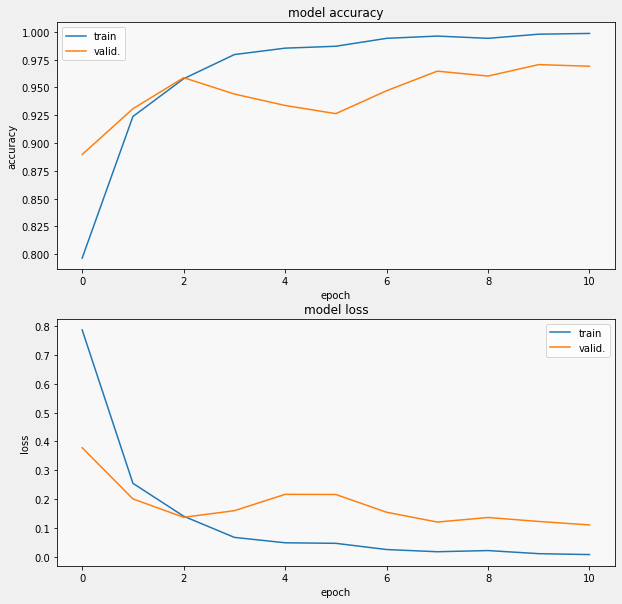

In [19]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [20]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels


# a couple of images to test predictions too
some_flowers, some_labels = dataset_to_numpy_util(get_validation_dataset(), 160)



In [21]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

10/10 [==============================] - 9s 929ms/step - loss: 0.1175 - accuracy: 0.9688
['roses', 'daisy', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'tulips', 'tulips', 'tulips', 'roses', 'roses', 'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'tulips', 'roses', 'roses', 'roses', 'daisy', 'dandelion', 'tulips', 'tulips', 'tulips', 'dandelion', 'roses', 'daisy', 'daisy', 'tulips', 'roses', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'roses', 'daisy', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'roses', 'sunflowers', 'daisy', 'dandelion', 'roses', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'tulips', 'daisy', 'roses', 'sunflowers', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'roses', 'dandelion', 'dandelion', 'dandelion', 'roses', 'dandelion', 'dandelion', 'tulips', 'dais

In [22]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save('./model', options=save_locally) # saving in Tensorflow's "saved model" format


In [24]:
# New in Tensorflow 2.4: models can be reloaded locally to TPUs in Tensorflow's SavedModel format

with strategy.scope():
    # TPUs need this extra setting to load from local disk, otherwise, they can only load models from GCS (Google Cloud Storage).
    # The setting instructs Tensorflow do the model loading on the local VM, not the TPU. Tensorflow can then still
    # instantiate the model on the TPU if the loading call is placed in a TPUStrategy scope. This setting does nothing on GPUs.
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    model = tf.keras.models.load_model('./model', options=load_locally) # loading in Tensorflow's "saved model" format

predictions = model.predict(tf.cast(some_flowers, tf.float32), batch_size=16)
evaluations = model.evaluate(tf.cast(some_flowers, tf.float32), some_labels, batch_size=16)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)


10/10 [==============================] - 7s 19ms/step - loss: 0.1191 - accuracy: 0.9688
['roses', 'daisy', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'tulips', 'tulips', 'tulips', 'roses', 'roses', 'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'tulips', 'roses', 'roses', 'roses', 'daisy', 'dandelion', 'tulips', 'tulips', 'tulips', 'dandelion', 'roses', 'daisy', 'daisy', 'tulips', 'roses', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'roses', 'daisy', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'roses', 'sunflowers', 'daisy', 'dandelion', 'roses', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'tulips', 'daisy', 'roses', 'sunflowers', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'roses', 'dandelion', 'dandelion', 'dandelion', 'roses', 'dandelion', 'dandelion', 'tulips', 'daisy

In [25]:
# https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7